In [ ]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/r1.0
!pip3 install waymo-open-dataset

Cloning into 'waymo-od'...
remote: Enumerating objects: 884, done.
remote: Total 884 (delta 0), reused 0 (delta 0), pack-reused 884
Receiving objects: 100% (884/884), 14.19 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (580/580), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/r1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a66eb0a Merge branch 'master' into r1.0
     |████████████████████████████████| 2.7MB 2.8MB/s 


In [ ]:
from google.colab import drive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import getpass
import os
import shutil
import zipfile
import tensorflow as tf

import os
import cv2
import tensorflow as tf
import math
import numpy as np
import itertools


from waymo_open_dataset import dataset_pb2 as open_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model


In [ ]:
drive.mount('/content/file1', force_remount=True)

Mounted at /content/file1


In [ ]:
!jar -xf "/content/file1/My Drive/train-1.zip"

In [ ]:
drive.flush_and_unmount()

In [ ]:
def getFiles(path):
  return [name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

In [ ]:
filesPath = "/content/train-1/"
files = getFiles(filesPath)
frames = []
frame = open_dataset.Frame()
print(files)
i = 0
for record in files:
  dataset = tf.data.TFRecordDataset(os.path.join(filesPath, record), compression_type='')
  for data in dataset:
    frame.ParseFromString(bytearray(data.numpy()))
    for index, image in enumerate(frame.images): 
      if(len(frame.camera_labels[index].labels)>0):
        frame_dict = {"image": image, "label": frame.camera_labels[index], "layout": [3, 3, index+1]}
        frames.append(frame_dict)    
print(len(frames))

['segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord', 'segment-10517728057304349900_3360_000_3380_000_with_camera_labels.tfrecord', 'segment-10500357041547037089_1474_800_1494_800_with_camera_labels.tfrecord', 'segment-10526338824408452410_5714_660_5734_660_with_camera_labels.tfrecord', 'segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord', 'segment-1051897962568538022_238_170_258_170_with_camera_labels.tfrecord']
5023


In [ ]:
test_frames = frames[4900:]
train_frames = frames[:4900]

In [ ]:
print(len(test_frames)+len(train_frames))

5023


In [ ]:
random.shuffle(test_frames)
random.shuffle(train_frames)

In [ ]:
def showImage(image, labels,layout):
  """Show a camera image and the given camera labels."""
  plt.figure(figsize=(25, 20))  
  ax = plt.subplot(*layout)
  colors = ['red','blue','green','yellow','orange']
  # Draw the camera labels.
  for label in labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label[1] - 0.5 * label[3],
            label[2] - 0.5 * label[4]),
        width=label[3],
        height=label[4],
        linewidth=1,
        edgecolor=colors[label[0]],
        facecolor='none'))
  # Show the camera image.
  image = image/255
  plt.imshow(image)
  plt.grid(False)
  plt.axis('off')

37


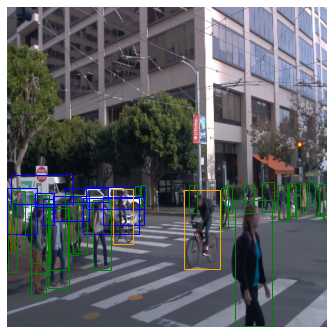

In [ ]:
def resizeForTrain(frame):
      image = cv2.imdecode(np.frombuffer(frame["image"].image, np.uint8), -1)
      labels = []
      print(len(frame["label"].labels))
      for label in frame["label"].labels:
        label_list = []
        label_list.append(label.type)
        label_list.append(int(label.box.center_x*(416/image.shape[1])))
        label_list.append(int(label.box.center_y*(416/image.shape[0])))
        label_list.append(int(label.box.length*(416/image.shape[1])))
        label_list.append(int(label.box.width*(416/image.shape[0])))
        labels.append(label_list)
      image = cv2.resize(image, (416,416))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
      return image,labels,frame["layout"]
image,labels,layout = resizeForTrain(frames[76])
showImage(image,labels,layout)

In [ ]:
def iou(box1,box2):
    x = 0
    y = 0
    if box2[0]<box1[0]:
      if (box2[1]<box1[0]):
        x =  0 
      else:
        if (box2[1]<box1[1]):
          x =  box2[1] - box1[0]
        else:
          x =  box1[1] - box1[0]
    else:
      if (box1[1]<box2[0]):
        x=  0
      else:
        if (box2[1]<box1[1]):
          x =  box2[1] - box2[0]
        else:
          x =  box1[1] - box2[0]
    
    if box2[2]<box1[2]:
      if (box2[3]<box1[2]):
        y =  0 
      else:
        if (box2[3]<box1[3]):
          y =  box2[3] - box1[2]
        else:
          y =  box1[3] - box1[2]
    else:
      if (box1[3]<box2[2]):
        y =  0
      else:
        if (box2[3]<box1[3]):
          y =  box2[3] - box2[2]
        else:
          y =  box1[3] - box2[2]
    
    
    numerator = x*y
    denominator = ((box1[1] - box1[0])*(box1[3] - box1[2])) + ((box2[1] - box2[0])*(box2[3] - box2[2])) - numerator
    return (numerator/denominator)
    

In [ ]:
def getAnchorBox(box, anchors):
  best_iou = 0
  idx = 0
  for i in range(0, len(anchors)):
    temp_iou = iou(box, anchors[i])
    if temp_iou > best_iou:
      best_iou = temp_iou
      idx = i
  return idx,best_iou

In [ ]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

In [ ]:
# Anchor box width and height found in https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

In [ ]:
def preProcess(frame):
  anchors = np.array([[0,1.07709888,  0,  1.78171903],  
                                        [0,2.71054693, 0,  5.12469308], 
                                        [0, 10.47181473, 0, 10.09646365],  
                                        [0, 5.48531347, 0,   8.11011331]])
  image, labels, layout = resizeForTrain(frame)
  result = np.zeros([13, 13, 4, 5 + 3])
  objects = np.zeros([1,1,1,50,4])
  count = 0
  for label in labels:
    center_x = label[1]
    center_y = label[2]
    width = label[3]
    height = label[4]
    center_x = center_x/32 #(32 = 416/13)
    center_y = center_y/32
    width = width/32
    height = height/32 
    grid_x = int(np.floor(center_x)) 
    grid_y = int(np.floor(center_y))
    if (grid_x<13 and grid_y<13):
      box = [center_x, center_y, width, height]
      idx, best_iou = getAnchorBox([0,width,0,height], anchors)
      result[grid_x, grid_y, int(idx), 0] = box[0]
      result[grid_x, grid_y, int(idx), 1] = box[1]
      result[grid_x, grid_y, int(idx), 2] = box[2]
      result[grid_x, grid_y, int(idx), 3] = box[3]
      result[grid_x, grid_y, int(idx), 4] = 1
      if (label[0]!=4):
        result[grid_x, grid_y, int(idx), 5 + label[0] - 1] = 1
      else:
        result[grid_x, grid_y, int(idx), 5 + 3 - 1] = 1
      objects[0,0,0,count] = box
      count = count + 1
      count = count%50 #In case there are more than 50 objects..
  return result,image/255,objects

In [ ]:
from tensorflow.keras.utils import Sequence

class trainGeneratorFrame(Sequence):
    def __init__(self):
        self.batchsize = 16        
    def __len__(self):
        return int(5000/16)  
    def __getitem__(self, idx):
      l_bound = idx*self.batchsize
      r_bound = (idx+1)*self.batchsize
      if r_bound > 5000:
            r_bound = 5000
            l_bound = r_bound - 16
      x_batch = np.zeros((self.batchsize, 416, 416, 3))                         
      b_batch = np.zeros((self.batchsize, 1     ,1 ,1 , 50, 4))   
      y_batch = np.zeros((self.batchsize, 13,  13, 4, 4+1+3))
      batchcount = 0
      for i in range(l_bound, r_bound):                 
          y_batch[batchcount],x_batch[batchcount],b_batch[batchcount] = preProcess(frames[i])
          batchcount = batchcount + 1
      return [x_batch, b_batch], y_batch

train_batch_generator = trainGeneratorFrame()
[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=1)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

36
14
30
4
60
35
14
30
4
61
35
13
30
3
61
36
x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 8)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

input_image = Input(shape=(416, 416, 3))
true_boxes  = Input(shape=(1, 1, 1, 50 , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(4 * (4 + 1 + 3), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((13, 13, 4, 4 + 1 + 3))(x)

output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

In [ ]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2020-10-16 03:57:00--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M   110KB/s    in 27m 26s 

2020-10-16 04:24:28 (121 KB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [ ]:
path_to_weight = "./yolov2.weights"

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


In [ ]:
LAMBDA_NO_OBJECT = 1
LAMBDA_OBJECT    = 5
LAMBDA_COORD     = 1
LAMBDA_CLASS     = 1
GRID_W = 13 
GRID_H = 13 
ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height
BOX    = int(len(ANCHORS)/2)
CLASS = 3
BATCH_SIZE = 16
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)



In [ ]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [ ]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [ ]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)
def print_min_max(vec,title):
  try:
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))
  except ValueError:  #raised if `y` is empty.
      pass
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh): 
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)

def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss


******************************
prepare inputs
y_pred before scaling = (16, 13, 13, 4, 8)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (16, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.45, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.46, MAX= 1.54
  bounding box x at iGRID_W=02 MIN= 2.45, MAX= 2.54
  bounding box x at iGRID_W=03 MIN= 3.45, MAX= 3.54
  bounding box x at iGRID_W=04 MIN= 4.45, MAX= 4.54
  bounding box x at iGRID_W=05 MIN= 5.46, MAX= 5.55
  bounding box x at iGRID_W=06 MIN= 6.46, MAX= 6.54
  bounding box x at iGRID_W=07 MIN= 7.46, MAX= 7.55
  bounding box x at iGRID_W=08 MIN= 8.45, MAX= 8.55
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.55
  bounding box x at iGRID_W=10 MIN=10.45, MAX=10.55
  bounding box x at iGRID_W=11 MIN=11.46, MAX=11.55
  bounding box x at iGRID_W=12 MIN=12.45, MAX=12.54
  bounding box y at iGRID_H=00 MIN= 0.46, MAX= 0.54
  bounding box y at iGRID_H=01 M

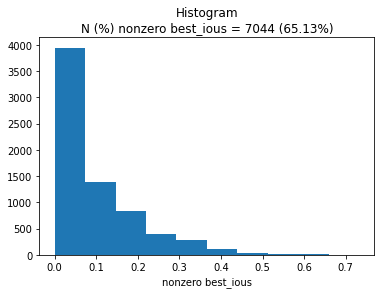

float64 float64
loss tf.Tensor(24.097473, shape=(), dtype=float32)


In [ ]:
print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = 3
BATCH_SIZE = 16
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 

print("\npred_box_xy {}".format(pred_box_xy.shape)) 

for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  class probability") 

# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0]
    pick = true_box_conf[:,:,igrid_w,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1]
    pick = true_box_conf[:,igrid_h,:,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)) )

LAMBDA_COORD = 1
loss_xywh, coord_mask  = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)

print("*"*30 + "\nouput\n" + "*"*30)

print("loss_xywh = {:4.3f}".format(loss_xywh))


LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))


true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = calc_IOU_pred_true_best(pred_box_xy,
                                       pred_box_wh,
                                       true_boxes)
    
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))
print("*"*30 + "\nouput\n" + "*"*30) 
print("best_ious.shape = {}".format(best_ious.shape))
vec  = best_ious
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()


print(y_batch.dtype, y_pred.dtype)
true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32')) 
print('loss', loss)


In [ ]:
 #Generator Function
def generateImagesNew(batchsize):
    x_batch = np.zeros((batchsize, 416, 416, 3))                         
    b_batch = np.zeros((batchsize, 1     ,1 ,1 , 50, 4))   
    y_batch = np.zeros((batchsize, 13,  13, 4, 4+1+3))
    image = np.zeros([1280, 1920, 3])
    ANCHORS = np.array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])
    babf = BestAnchorBoxFinder(ANCHORS)

    frame = open_dataset.Frame()      
    filesPath = "/content/train-1/"
    count = 0
    while True:  
      for frame in train_frames:
              if(count>=batchsize):
                yield  [x_batch, b_batch], y_batch
                count = 0
              image = cv2.imdecode(np.frombuffer(frame["image"].image, np.uint8), -1)
              labels = []
              for label in frame["label"].labels:
                label_list = []
                if(label.type!= 4):
                  label_list.append(label.type)
                else:
                  label_list.append(3)
                label_list.append(int(label.box.center_x*(416/1920)))
                label_list.append(int(label.box.center_y*(416/1280)))
                label_list.append(int(label.box.length*(416/1920)))
                label_list.append(int(label.box.width*(416/1280)))
                labels.append(label_list)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, (416,416)) 
              x_batch[count] = image/255
              objectCount = 0
              for label in labels:
                center_x = label[1]
                center_y = label[2]
                width = label[3]
                height = label[4]
                center_x = center_x/32 #(32 = 416/13)
                center_y = center_y/32
                width = width/32
                height = height/32 
                grid_x = int(np.floor(center_x)) 
                grid_y = int(np.floor(center_y))
                if (grid_x<13 and grid_y<13):
                  box = [center_x, center_y, width, height]
                  idx, best_iou = babf.find(width, height)
                  y_batch[count,grid_x, grid_y, int(idx), 0] = box[0]
                  y_batch[count,grid_x, grid_y, int(idx), 1] = box[1]
                  y_batch[count,grid_x, grid_y, int(idx), 2] = box[2]
                  y_batch[count,grid_x, grid_y, int(idx), 3] = box[3]
                  y_batch[count,grid_x, grid_y, int(idx), 4] = 1
                  #print(5 + label[0] - 1)
                  y_batch[count,grid_x, grid_y, int(idx), 5 + label[0] - 1] = 1
                  b_batch[count, 0,0,0,objectCount] = box
                  objectCount = objectCount + 1
                  objectCount = objectCount%50
              count = count + 1      
              #print(count)
trainGeneratorNew = generateImagesNew(batchsize= 16)

In [ ]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=custom_loss ,optimizer=optimizer)
tf.config.experimental_run_functions_eagerly(True)

model.fit_generator(generator        =  trainGeneratorNew, 
                    steps_per_epoch  = 300,
                    max_queue_size   = 3,
                    epochs           = 1, 
                    verbose          = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


106/300 [=========>....................] - ETA: 2:26:34 - loss: 18.7169

In [ ]:
history = model.fit_generator(generator        =  trainGeneratorNew, 
                    steps_per_epoch  = 300,
                    max_queue_size   = 3,
                    epochs           = 1, 
                    verbose          = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


300/300 [==============================] - 11780s 39s/step - loss: 29.1440


In [ ]:
history = model.fit_generator(generator        =  trainGeneratorNew, 
                    steps_per_epoch  = 300,
                    max_queue_size   = 3,
                    epochs           = 1, 
                    verbose          = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


300/300 [==============================] - 11721s 39s/step - loss: 26.0359


In [ ]:
history = model.fit_generator(generator        =  trainGeneratorNew, 
                    steps_per_epoch  = 300,
                    max_queue_size   = 3,
                    epochs           = 1, 
                    verbose          = 1)

NameError: ignored

In [ ]:
model.save("objectnormm-II")

INFO:tensorflow:Assets written to: objectnormm-II/assets


In [ ]:
 #Generator Function
def generateImagesTest(batchsize):
    x_batch = np.zeros((batchsize, 416, 416, 3))                         
    b_batch = np.zeros((batchsize, 1     ,1 ,1 , 50, 4))   
    y_batch = np.zeros((batchsize, 13,  13, 4, 4+1+3))
    image = np.zeros([1280, 1920, 3])
    ANCHORS = np.array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])
    babf = BestAnchorBoxFinder(ANCHORS)

    frame = open_dataset.Frame()      
    filesPath = "/content/train-1/"
    count = 0
    while True:  
      for frame in test_frames:
              if(count>=batchsize):
                yield  [x_batch, b_batch], y_batch
                count = 0
              image = cv2.imdecode(np.frombuffer(frame["image"].image, np.uint8), -1)
              labels = []
              for label in frame["label"].labels:
                label_list = []
                if(label.type!= 4):
                  label_list.append(label.type)
                else:
                  label_list.append(3)
                label_list.append(int(label.box.center_x*(416/1920)))
                label_list.append(int(label.box.center_y*(416/1280)))
                label_list.append(int(label.box.length*(416/1920)))
                label_list.append(int(label.box.width*(416/1280)))
                labels.append(label_list)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, (416,416)) 
              x_batch[count] = image/255
              objectCount = 0
              for label in labels:
                center_x = label[1]
                center_y = label[2]
                width = label[3]
                height = label[4]
                center_x = center_x/32 #(32 = 416/13)
                center_y = center_y/32
                width = width/32
                height = height/32 
                grid_x = int(np.floor(center_x)) 
                grid_y = int(np.floor(center_y))
                if (grid_x<13 and grid_y<13):
                  box = [center_x, center_y, width, height]
                  idx, best_iou = babf.find(width, height)
                  y_batch[count,grid_x, grid_y, int(idx), 0] = box[0]
                  y_batch[count,grid_x, grid_y, int(idx), 1] = box[1]
                  y_batch[count,grid_x, grid_y, int(idx), 2] = box[2]
                  y_batch[count,grid_x, grid_y, int(idx), 3] = box[3]
                  y_batch[count,grid_x, grid_y, int(idx), 4] = 1
                  #print(5 + label[0] - 1)
                  y_batch[count,grid_x, grid_y, int(idx), 5 + label[0] - 1] = 1
                  b_batch[count, 0,0,0,objectCount] = box
                  objectCount = objectCount + 1
                  objectCount = objectCount%50
              count = count + 1      
              #print(count)
testGenerator = generateImagesTest(batchsize= 16)

In [ ]:
testHistory = model.evaluate(testGenerator, steps = int(len(test_frames) // 16), 
                   batch_size = 16)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


7/7 [==============================] - 53s 8s/step - loss: 19.5105


In [ ]:
testHistory = model.evaluate(testGenerator, steps = int(len(test_frames) // 16), 
                   batch_size = 16)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


7/7 [==============================] - 53s 8s/step - loss: 18.4244


In [ ]:
image = cv2.imread("/content/yolotTest.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (416,416)) 
image = image/255


In [ ]:
print(image.shape) 
X_test = np.expand_dims(image,0)
print(X_test.shape)

(416, 416, 3)
(1, 416, 416, 3)


In [ ]:

dummy_array = np.zeros((1,1,1,1,50,4))
Y_pred = model.predict([X_test, dummy_array])

print(Y_pred.shape)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(1, 13, 13, 4, 8)


In [ ]:
print(Y_pred[0])

[[[[ 0.04073584 -0.04288089 -0.08071398 ... -0.21659914  0.12642865
     0.02236445]
   [-0.04652438  0.10939206  0.125571   ...  0.02530482  0.09011544
    -0.07209929]
   [-0.0408591  -0.30119127 -0.10106474 ...  0.01441849  0.06854819
    -0.08040745]
   [-0.07509319  0.09541237 -0.02861713 ...  0.02302282  0.09753089
     0.04025244]]

  [[ 0.00872816 -0.02516223 -0.14300764 ... -0.18261859  0.09348577
    -0.12517564]
   [-0.00817885  0.07845456  0.11627884 ...  0.00781566  0.11535558
    -0.04357517]
   [-0.03708634 -0.20946485 -0.14502713 ... -0.0483433  -0.03149406
    -0.05793821]
   [-0.04594085  0.09328841 -0.10057613 ...  0.05992066  0.10886498
     0.08657312]]

  [[ 0.01964906 -0.02774591 -0.09720369 ... -0.17746942  0.09129106
    -0.14371127]
   [ 0.00875656  0.18736118  0.12947027 ...  0.04863482  0.07851788
    -0.04200084]
   [-0.07945987 -0.19264072 -0.08290499 ... -0.01462852  0.03118688
    -0.12805103]
   [ 0.00195873  0.10069457 -0.00234212 ...  0.11242194 -0.01

In [ ]:
ANCHORS1 = np.array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331])
class OutputRescaler(object):
    def __init__(self,ANCHORS1):
        self.ANCHORS = ANCHORS1

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

In [ ]:
netout         = Y_pred[0]
outputRescaler = OutputRescaler(ANCHORS1=ANCHORS1)
netout_scale   = outputRescaler.fit(netout)

In [ ]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.2
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.015
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 676 bounding boxes with top class probability > 0.015

obj_threshold=0.2
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 37 bounding boxes with top class probability > 0.2
